# The open-source toolbox of the nuclear safeguards data scientist: supplement

The goal of this notebook is to demonstrate the use of machine learning models for prediction of spent fuel parameters such as BU, IE, and CT as well as to perform classification between UOX and MOX fuel using artificial neural networks.

The following imports are necessary:
- For matrix operations and creation of dataframes
    - Numpy
    - Pandas
- For producing visualiztions of data
    - Matplotlib
    - Seaborn
- For data preprocessing using `Scikit-learn`
    - decomposition
    - Scalars: `StandardScaler`, `MinMaxScaler`
    - Data set splitters: `train_test_split`, `KFold`
- For setting up deep learning models
    - `keras-tuner`
    - `tensorflow`
    - `tensorflow` layers, activations and callbacks options

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn import decomposition
from mpl_toolkits.mplot3d import axes3d

# import all deep learning dependencies
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
import keras
import tensorflow as tf
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

## Loading the data

Load the Uppsala University PWR fuel data set. Available **[here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7588691/)**.

The data set contains the atomic density of 279 nuclides (fission products and actinides), the total spontaneous fission rate **(‘TOT_SF’)**, total photon emission rate **(‘TOT_GSRC’)**, activity **(‘TOT_A’)** and decay heat **(‘TOT_H’)** at 789,406 different BU, CT, IE configurations for UO2 fuel and at 531,991 different BU, CT, IPC configurations for MOX fuel.

Firstly, we load in the entire data set and see all the available columns.

In [5]:
print(pd.read_csv('UU_PWR_UOX-MOX.csv', index_col=0, nrows=0).columns.tolist())

['BU', 'CT', 'IE', 'fuelType', 'TOT_SF', 'TOT_GSRC', 'TOT_A', 'TOT_H', 'H1', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Be9', 'B10', 'B11', 'C12', 'N14', 'N15', 'O16', 'O17', 'Ga69', 'Ga71', 'Ge70', 'Ge72', 'Ge73', 'Ge74', 'Ge76', 'As74', 'As75', 'Se74', 'Se76', 'Se77', 'Se78', 'Se79', 'Se80', 'Se82', 'Br79', 'Br81', 'Kr78', 'Kr80', 'Kr82', 'Kr83', 'Kr84', 'Kr85', 'Kr86', 'Rb85', 'Rb86', 'Rb87', 'Sr84', 'Sr86', 'Sr87', 'Sr88', 'Sr89', 'Sr90', 'Y89', 'Y90', 'Y91', 'Zr90', 'Zr91', 'Zr92', 'Zr93', 'Zr94', 'Zr95', 'Zr96', 'Nb93', 'Nb94', 'Nb95', 'Mo92', 'Mo94', 'Mo95', 'Mo96', 'Mo97', 'Mo98', 'Mo99', 'Mo100', 'Tc99', 'Ru98', 'Ru99', 'Ru100', 'Ru101', 'Ru102', 'Ru103', 'Ru104', 'Ru105', 'Ru106', 'Rh103', 'Rh105', 'Pd102', 'Pd104', 'Pd105', 'Pd106', 'Pd107', 'Pd108', 'Pd110', 'Ag107', 'Ag109', 'Ag111', 'Ag110m', 'Cd106', 'Cd108', 'Cd110', 'Cd111', 'Cd112', 'Cd113', 'Cd114', 'Cd115', 'Cd116', 'Cd115m', 'In113', 'In115', 'Sn112', 'Sn113', 'Sn114', 'Sn115', 'Sn116', 'Sn117', 'Sn118', 'Sn119', 'Sn

In [6]:
colInterest=['BU','CT','IE','fuelType','Ce141','Nb95','Y91','Zr95','Ce144','Ru106','Cs134','Eu154','Cs137']
fueldata=pd.read_csv('UU_PWR_UOX-MOX.csv',header = 0, usecols=colInterest)
fueldata.head()

,BU,CT,IE,fuelType,Y91,Zr95,Nb95,Ru106,Cs134,Cs137,Ce141,Ce144,Eu154
0,5.0,0.00,1.5,UOX,2.397170e-06,3.166171e-06,1.478996e-06,1.505257e-06,1.924658e-07,0.000008,1.709536e-06,0.000005,2.945246e-08
1,5.0,91.25,1.5,UOX,8.132495e-07,1.178869e-06,1.036539e-06,1.269661e-06,1.769621e-07,0.000008,2.441769e-07,0.000004,2.886479e-08
2,5.0,182.50,1.5,UOX,2.758981e-07,4.389314e-07,4.656899e-07,1.070940e-06,1.627073e-07,0.000008,3.487634e-08,0.000003,2.828885e-08
3,5.0,273.75,1.5,UOX,9.359952e-08,1.634285e-07,1.864606e-07,9.033212e-07,1.496008e-07,0.000007,4.981466e-09,0.000003,2.772439e-08
4,5.0,365.00,1.5,UOX,3.175401e-08,6.084978e-08,7.156699e-08,7.619375e-07,1.375500e-07,0.000007,7.115140e-10,0.000002,2.717120e-08


Plot of Cs-137 content for different BU and CT values, The 1e24 multiplier gives the concentration in atoms/cm3

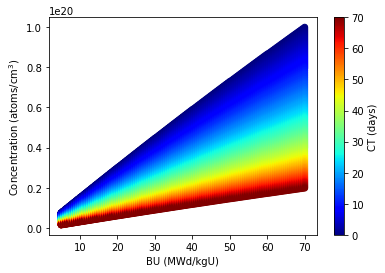

In [7]:
subfuel=fueldata[(fueldata['IE']==3.0) & (fueldata['fuelType']=='UOX')]
plt.figure()
plt.scatter(subfuel['BU'], subfuel['Cs137']*1e24,c=subfuel['CT']/365, cmap='jet')
plt.xlabel('BU (MWd/kgU)')
plt.ylabel('Concentration (atoms/cm$^3$)')
plt.colorbar(label='CT (days)')
plt.show()

## Convert to activity concentration

Using nuclide concentrations to compute radionuclide activities (can be actually measured) for radionuclides of interest

In [8]:
halflife={'Y91':58.5,
          'Zr95':64,
          'Nb95':35,
          'Ru106':372,
          'Cs134':2.065*365,
          'Cs137':30.1*365,
          'Eu154':8.6*365,
          'Ce141':32.5,
          'Ce144':285
          }
d2s=86400
for iso in halflife:
    fueldata[iso+'A']=fueldata[iso]*1e24*(np.log(2)/(halflife[iso]*d2s))
fueldata.head()

,BU,CT,IE,fuelType,Y91,Zr95,Nb95,Ru106,Cs134,Cs137,...,Eu154,Y91A,Zr95A,Nb95A,Ru106A,Cs134A,Cs137A,Eu154A,Ce141A,Ce144A
0,5.0,0.00,1.5,UOX,2.397170e-06,3.166171e-06,1.478996e-06,1.505257e-06,1.924658e-07,0.000008,...,2.945246e-08,3.287416e+11,3.968863e+11,3.390087e+11,3.246231e+10,2.048577e+09,5.569977e+09,7.527349e+07,4.219944e+11,1.397063e+11
1,5.0,91.25,1.5,UOX,8.132495e-07,1.178869e-06,1.036539e-06,1.269661e-06,1.769621e-07,0.000008,...,2.886479e-08,1.115269e+11,1.477737e+11,2.375906e+11,2.738146e+10,1.883558e+09,5.537918e+09,7.377154e+07,6.027441e+10,1.118922e+11
2,5.0,182.50,1.5,UOX,2.758981e-07,4.389314e-07,4.656899e-07,1.070940e-06,1.627073e-07,0.000008,...,2.828885e-08,3.783594e+10,5.502099e+10,1.067433e+11,2.309584e+10,1.731832e+09,5.506043e+09,7.229955e+07,8.609129e+09,8.961557e+10
3,5.0,273.75,1.5,UOX,9.359952e-08,1.634285e-07,1.864606e-07,9.033212e-07,1.496008e-07,0.000007,...,2.772439e-08,1.283599e+10,2.048611e+10,4.273963e+10,1.948099e+10,1.592328e+09,5.474351e+09,7.085694e+07,1.229661e+09,7.177401e+10
4,5.0,365.00,1.5,UOX,3.175401e-08,6.084978e-08,7.156699e-08,7.619375e-07,1.375500e-07,0.000007,...,2.717120e-08,4.354661e+09,7.627650e+09,1.640425e+10,1.643191e+10,1.464062e+09,5.442842e+09,6.944312e+07,1.756353e+08,5.748453e+10


## Correlations

Correlation of signatures to targets for MOX

These correlations may be used for feature ranking for setting up the ML problem in later steps.

$corr(x_iy)=\frac{E(x_i\cdot y)-E(x_i)\cdot E(y)}{\sigma_{x_i}\sigma_y}\cdot 100 (\%)$


In [9]:
colInterest=['BU','CT','IE','fuelType','Ce141A','Nb95A','Y91A','Zr95A','Ce144A','Ru106A','Cs134A','Eu154A','Cs137A']
subfuel=fueldata[fueldata['fuelType']=='MOX'][colInterest]
subfuel.head()

,BU,CT,IE,fuelType,Ce141A,Nb95A,Y91A,Zr95A,Ce144A,Ru106A,Cs134A,Eu154A,Cs137A
789406,5.0,0.00,4.0,MOX,3.848142e+11,2.621000e+11,1.779205e+11,3.112505e+11,1.074759e+11,9.475441e+10,1.705952e+09,1.057081e+08,5.694467e+09
789407,5.0,91.25,4.0,MOX,5.496388e+10,1.857096e+11,6.036024e+10,1.158887e+11,8.607856e+10,7.992389e+10,1.568533e+09,1.035989e+08,5.661691e+09
789408,5.0,182.50,4.0,MOX,7.850615e+09,8.361037e+10,2.047745e+10,4.314917e+10,6.894118e+10,6.741457e+10,1.442183e+09,1.015317e+08,5.629104e+09
789409,5.0,273.75,4.0,MOX,1.121321e+09,3.350119e+10,6.947056e+09,1.606584e+10,5.521569e+10,5.686316e+10,1.326011e+09,9.950583e+07,5.596704e+09
789410,5.0,365.00,4.0,MOX,1.601608e+08,1.286201e+10,2.356816e+09,5.981839e+09,4.422280e+10,4.796320e+10,1.219197e+09,9.752037e+07,5.564490e+09


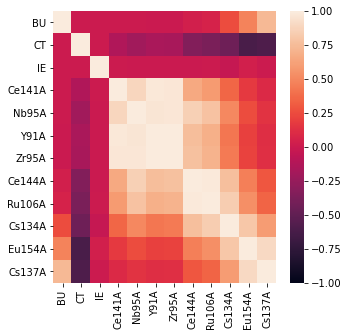

In [10]:
plt.figure(figsize=(5,5))
sns.heatmap(subfuel.corr(),annot=False,vmin=-1,vmax=1)
plt.savefig('heatmap1.png')
plt.show()

Correlation of signatures to targets for UOX

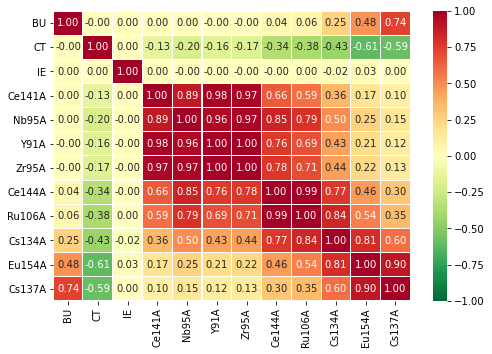

In [12]:
f, ax = plt.subplots(figsize=(8, 5))
corr = subfuel.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap='RdYlGn_r',fmt='.2f',
                     linewidths=.05, vmin=-1,vmax=1)
    # plt.yticks(np.arange(16)+1.5,tl, rotation=0, fontsize="10", va="center")
f.subplots_adjust(top=0.93)
#t= f.suptitle('PWR Fuel Feature Correlation Heatmap', fontsize=14)
plt.savefig('heatmap.png', dpi=300, bbox_inches = "tight")
plt.show()

## Principal component analysis

PCA helps in dimensionality reduction to further simplify the ML problem. It can help weed out features which are least correlated to the BU, IE and CT.


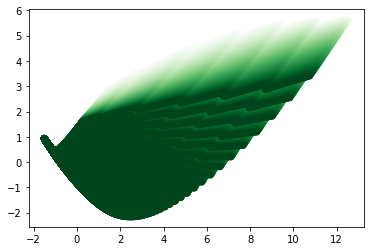

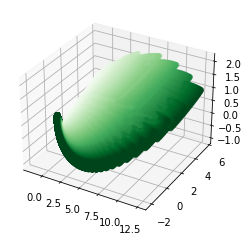

In [13]:
features = ['Ru106', 'Cs134', 'Eu154', 'Cs137']
subfuel=fueldata[(fueldata["BU"]>= 15) & (fueldata["IE"] <= 5.5) & (fueldata["fuelType"] == 'UOX')]
X = subfuel.loc[:, features].values
X = StandardScaler().fit_transform(X)
pca = decomposition.PCA(n_components=4)
pca.fit(X)
Xt = pca.transform(X)
plt.scatter(Xt[:,0],Xt[:,1],c=subfuel.IE, cmap='Greens')
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(Xt[:,0], Xt[:,1], Xt[:,2], c=subfuel.BU, cmap='Greens');
plt.show()


Here i try to mimic http://uu.diva-portal.org/smash/get/diva2:1172034/FULLTEXT01.pdf Fig. 7.4 and Fig. 7.5 on page 51 and 52.

1-10y fuel, so only some of the nuclide activities are included, normalized to sum=1.

Hard to visually compare, nevertheless the UOX seems to have a "saddle" shape in or case as well, whereas the MOX has a simpler shape.
 

In [14]:
subfuel=fueldata[(fueldata["CT"]>=1*365) & (fueldata["CT"] <= 10*365) & (fueldata["BU"] <= 60)].sample(n=10000,random_state=1)
subfuelUOX=subfuel[(subfuel["fuelType"] == 'UOX')]
subfuelMOX=subfuel[(subfuel["fuelType"] == 'MOX')]
features=['Ce144A','Ru106A','Cs134A','Eu154A','Cs137A']
XUOX = subfuelUOX.loc[:, features]
XMOX = subfuelMOX.loc[:, features]
XUOX[features]=XUOX[features].apply(lambda row: row/sum(row.values), axis=1)
XMOX[features]=XMOX[features].apply(lambda row: row/sum(row.values), axis=1)
XUOX = XUOX.values
XMOX = XMOX.values
#XUOX = StandardScaler().fit_transform(XUOX)
#XMOX = StandardScaler().fit_transform(XMOX)
pcaU = decomposition.PCA(n_components=5)
pcaU.fit(XUOX)
XtUOX = pcaU.transform(XUOX)
pcaM = decomposition.PCA(n_components=5)
pcaM.fit(XUOX)
XtMOX = pcaM.transform(XMOX)

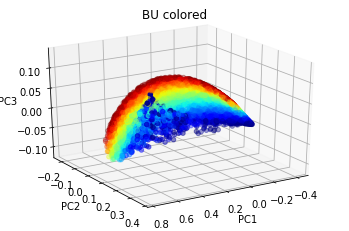

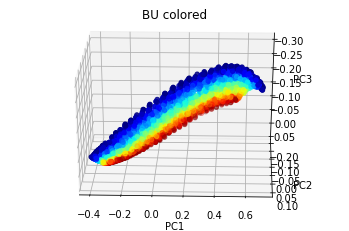

In [37]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(XtUOX[:,0], XtUOX[:,1], XtUOX[:,2], c=subfuelUOX.BU, cmap='jet');
ax.set_title('BU colored')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.view_init(elev=25., azim=58)
plt.show()


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(XtMOX[:,0], XtMOX[:,1], XtMOX[:,2], c=subfuelMOX.BU, cmap='jet');
ax.set_title('BU colored')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.view_init(elev=-154, azim=-92)
plt.show()

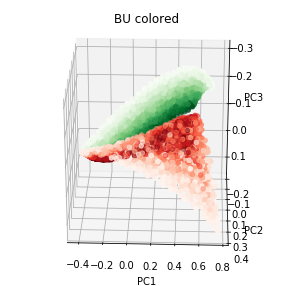

In [45]:
%matplotlib inline
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(XtUOX[:,0], XtUOX[:,1], XtUOX[:,2], c=subfuelUOX.BU, cmap='Reds');
ax.scatter3D(XtMOX[:,0], XtMOX[:,1], XtMOX[:,2], c=subfuelMOX.BU, cmap='Greens');
ax.set_title('BU colored')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.view_init(elev=-154, azim=-92)
plt.show()

## Regression problem

We now have everything we need to set up a ML problem for regression to predict fuel parameters BU, IE and CT.

In [3]:
print(pd.read_csv('UU_PWR_UOX-MOX.csv', index_col=0, nrows=0).columns.tolist())

['BU', 'CT', 'IE', 'fuelType', 'TOT_SF', 'TOT_GSRC', 'TOT_A', 'TOT_H', 'H1', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Be9', 'B10', 'B11', 'C12', 'N14', 'N15', 'O16', 'O17', 'Ga69', 'Ga71', 'Ge70', 'Ge72', 'Ge73', 'Ge74', 'Ge76', 'As74', 'As75', 'Se74', 'Se76', 'Se77', 'Se78', 'Se79', 'Se80', 'Se82', 'Br79', 'Br81', 'Kr78', 'Kr80', 'Kr82', 'Kr83', 'Kr84', 'Kr85', 'Kr86', 'Rb85', 'Rb86', 'Rb87', 'Sr84', 'Sr86', 'Sr87', 'Sr88', 'Sr89', 'Sr90', 'Y89', 'Y90', 'Y91', 'Zr90', 'Zr91', 'Zr92', 'Zr93', 'Zr94', 'Zr95', 'Zr96', 'Nb93', 'Nb94', 'Nb95', 'Mo92', 'Mo94', 'Mo95', 'Mo96', 'Mo97', 'Mo98', 'Mo99', 'Mo100', 'Tc99', 'Ru98', 'Ru99', 'Ru100', 'Ru101', 'Ru102', 'Ru103', 'Ru104', 'Ru105', 'Ru106', 'Rh103', 'Rh105', 'Pd102', 'Pd104', 'Pd105', 'Pd106', 'Pd107', 'Pd108', 'Pd110', 'Ag107', 'Ag109', 'Ag111', 'Ag110m', 'Cd106', 'Cd108', 'Cd110', 'Cd111', 'Cd112', 'Cd113', 'Cd114', 'Cd115', 'Cd116', 'Cd115m', 'In113', 'In115', 'Sn112', 'Sn113', 'Sn114', 'Sn115', 'Sn116', 'Sn117', 'Sn118', 'Sn119', 'Sn

Use a selection of isotopes for the regression problem

In [4]:
colInterest=['BU','CT','IE','fuelType','Ru106','Cs134','Eu154','Cs137','TOT_SF','TOT_GSRC', 'TOT_A','Pu236','Pu237','Pu238', 'Pu239','Pu240','Pu241','Pu242','Pu243','Pu244']
fueldata=pd.read_csv('UU_PWR_UOX-MOX.csv',header = 0, usecols=colInterest)
fueldata.head()

,BU,CT,IE,fuelType,TOT_SF,TOT_GSRC,TOT_A,Ru106,Cs134,Cs137,Eu154,Pu236,Pu237,Pu238,Pu239,Pu240,Pu241,Pu242,Pu243,Pu244
0,5.0,0.00,1.5,UOX,5.01445,1.196600e+13,1.084540e+13,1.505257e-06,1.924658e-07,0.000008,2.945246e-08,4.160911e-16,1.138704e-13,4.716275e-08,0.000062,0.00001,0.000003,2.384159e-07,5.640417e-11,1.022307e-12
1,5.0,91.25,1.5,UOX,3.91920,2.959020e+11,5.848210e+11,1.269661e-06,1.769621e-07,0.000008,2.886479e-08,3.920824e-16,2.807413e-14,4.982796e-08,0.000064,0.00001,0.000003,2.384275e-07,3.760617e-27,1.022400e-12
2,5.0,182.50,1.5,UOX,3.11170,1.181050e+11,2.796190e+11,1.070940e-06,1.627073e-07,0.000008,2.828885e-08,3.694653e-16,6.921396e-15,5.021822e-08,0.000064,0.00001,0.000003,2.384274e-07,3.760617e-27,1.022400e-12
3,5.0,273.75,1.5,UOX,2.56308,5.384120e+10,1.670140e+11,9.033212e-07,1.496008e-07,0.000007,2.772439e-08,3.481593e-16,1.706382e-15,5.045058e-08,0.000064,0.00001,0.000003,2.384274e-07,3.760617e-27,1.022400e-12
4,5.0,365.00,1.5,UOX,2.19006,2.882190e+10,1.173000e+11,7.619375e-07,1.375500e-07,0.000007,2.717120e-08,3.280883e-16,4.206838e-16,5.057591e-08,0.000064,0.00001,0.000003,2.384273e-07,3.760617e-27,1.022400e-12


In [5]:
subfuel=fueldata[(fueldata['fuelType']=='MOX')]

In [74]:
subfuel.info

<bound method DataFrame.info of            BU        CT    IE fuelType    TOT_SF      TOT_GSRC         TOT_A  \
789406    5.0      0.00   4.0      MOX   739.365  1.044220e+13  9.805770e+12   
789407    5.0     91.25   4.0      MOX   650.607  2.768340e+11  6.382650e+11   
789408    5.0    182.50   4.0      MOX   586.433  1.098480e+11  3.613290e+11   
789409    5.0    273.75   4.0      MOX   541.647  5.307760e+10  2.604170e+11   
789410    5.0    365.00   4.0      MOX   510.023  3.122800e+10  2.132580e+11   
...       ...       ...   ...      ...       ...           ...           ...   
1321392  70.0  24090.00  10.0      MOX  3579.850  1.504260e+10  4.816070e+10   
1321393  70.0  24455.00  10.0      MOX  3464.460  1.484530e+10  4.708880e+10   
1321394  70.0  24820.00  10.0      MOX  3353.390  1.465220e+10  4.605220e+10   
1321395  70.0  25185.00  10.0      MOX  3246.480  1.446340e+10  4.504970e+10   
1321396  70.0  25550.00  10.0      MOX  3143.590  1.427870e+10  4.408000e+10   

       

#### Define the ANN skeleton for model structure search using `keras-tuner`

In [20]:
# define model search skeleton
def nn_model1(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 10)):
        model.add(Dense(units=hp.Int('units_' + str(i),
                                            min_value=16,
                                            max_value=128,
                                            step=16),
                               activation='tanh'))
    model.add(Dense(3, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adamax(
        hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error', tf.keras.metrics.RootMeanSquaredError()])
    return model

#### Model feature selection and data scaling

In [21]:
############### feature selection
features = ['Ru106','Cs134','Eu154','Cs137','TOT_SF','TOT_GSRC', 'TOT_A','Pu236','Pu237','Pu238', 'Pu239','Pu240','Pu241','Pu242','Pu243','Pu244']
df_f = subfuel[(subfuel['CT']/365<20.0)] #consider assemblies with CT<20
x_in = df_f[features] #prediction features (3 important isotopes)
y_in = df_f[['CT', 'BU', 'IE']] #cooling time: output variable
x_train, x_test, y_train, y_test = train_test_split(x_in, y_in, test_size=0.4) ##train-test split
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5) ##val-test split
scaler = StandardScaler()
x_tr = scaler.fit_transform(x_train)
x_vl = scaler.transform(x_val)
scaler_y = StandardScaler()
y_tr = scaler_y.fit_transform(y_train)
y_vl = scaler_y.transform(y_val)

#### Setting up tuner search parameters in `keras-tuner`

In [22]:
# define Bayesian hp search parameters
tuner = kt.tuners.bayesian.BayesianOptimization(
    nn_model1,
    objective=kt.Objective("val_root_mean_squared_error", direction="min"),
    max_trials=100,
    executions_per_trial=2,    
    directory='/Users/vaibhavmishra/Downloads/IAEA/',
    project_name='PWRNN3varbopt')
tuner.search(x_tr, y_tr, epochs=20, validation_data=(x_vl, y_vl))

Trial 98 Complete [00h 06m 30s]
val_root_mean_squared_error: 0.005913961445912719

Best val_root_mean_squared_error So Far: 0.005474971840158105
Total elapsed time: 07h 43m 26s
INFO:tensorflow:Oracle triggered exit


In [27]:
best_model = tuner.get_best_models()[0]
best_hyperparams = tuner.get_best_hyperparameters(1)[0]
print(best_hyperparams)

#### Using the optimum model structure obtained from `keras-tuner`

In [28]:
# use best model
model = Sequential()
model.add(Dense(64, input_dim=16, kernel_initializer='RandomNormal', activation='tanh')) #layer 0
model.add(Dense(64, activation='tanh'))  #layer 1
model.add(Dense(16, activation='tanh')) #layer 2
model.add(Dense(14, activation='tanh')) #layer 3
model.add(Dense(16, activation='tanh')) #layer 4
model.add(Dense(3, activation='linear'))
model.summary()

import _datetime
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + _datetime.date.today().strftime("%Y%m%d-%H%M%S")
opt = keras.optimizers.Adamax(learning_rate=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='val_root_mean_squared_error', verbose=1,save_best_only=True, mode='auto', period=1)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = model.fit(x_tr, y_tr, epochs=200, batch_size=1000,  verbose=1, validation_data=(x_vl, y_vl), callbacks=[tensorboard_callback, checkpoint, reduce_lr])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                1088      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_10 (Dense)             (None, 14)                238       
_________________________________________________________________
dense_11 (Dense)             (None, 16)                240       
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 51        
Total params: 6,817
Trainable params: 6,817
Non-trainable params: 0
____________________________________________________

#### Visualization of predicted fuel parameters

##### Visualization of predicted CT and computation of RMSE

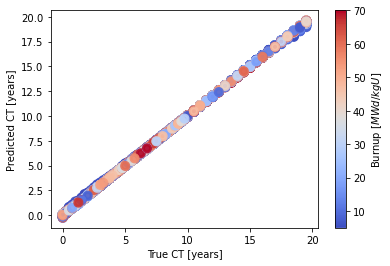

14.494742640102446 days


In [29]:
plt.scatter(y_test['CT']/365, scaler_y.inverse_transform(model.predict(scaler.transform(x_test)))[:,0]/365, c=subfuel.loc[y_test.index]['BU'], cmap='coolwarm', s=50, alpha=0.9, lw=3)
plt.ylabel("Predicted CT [years]")
plt.xlabel("True CT [years]")
cbar = plt.colorbar()
cbar.set_label(r'Burnup [$MWd/kgU]$')
plt.savefig('/Users/vaibhavmishra/Downloads/NNtest.png',dpi=300)
# _ = plt.plot([10, 70], [10, 70])
plt.show()
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test['CT'], scaler_y.inverse_transform(model.predict(scaler.transform(x_test)))[:,0], squared=False), r"days")

##### Visualization of predicted IE and computation of RMSE

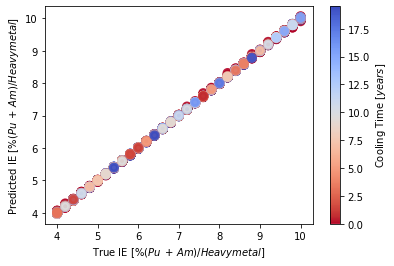

0.007189926690229239 %(Pu + Am)/Heavy metal


In [34]:
# preds = model.predict(x_test)
plt.scatter(y_test['IE'], scaler_y.inverse_transform(model.predict(scaler.transform(x_test)))[:,2], c=subfuel.loc[y_test.index]['CT']/365, cmap='coolwarm_r', s=50, alpha=0.9, lw=3)
plt.ylabel("Predicted IE $[\%(Pu + Am)/Heavy metal]$")
plt.xlabel("True IE $[\%(Pu + Am)/Heavy metal]$")
cbar = plt.colorbar()
cbar.set_label(r'Cooling Time [$years]$')
plt.savefig('/Users/vaibhavmishra/Downloads/NNtest1.png',dpi=300)
# _ = plt.plot([10, 70], [10, 70])
plt.show()
print(mean_squared_error(y_test['IE'], scaler_y.inverse_transform(model.predict(scaler.transform(x_test)))[:,2], squared=False), r"%(Pu + Am)/Heavy metal")

##### Visualization of predicted BU and computation of RMSE

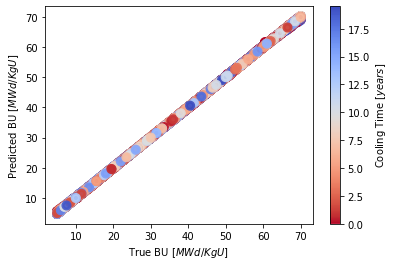

0.0842796747873332 MWd/KgU


In [31]:
# preds = model.predict(x_test)
plt.scatter(y_test['BU'], scaler_y.inverse_transform(model.predict(scaler.transform(x_test)))[:,1], c=subfuel.loc[y_test.index]['CT']/365, cmap='coolwarm_r', s=50, alpha=0.9, lw=3)
plt.ylabel(r'Predicted BU [$MWd/KgU]$')
plt.xlabel(r'True BU [$MWd/KgU]$')
cbar = plt.colorbar()
cbar.set_label(r'Cooling Time [$years]$')
plt.savefig('/Users/vaibhavmishra/Downloads/NNtest2.png',dpi=300)
# _ = plt.plot([10, 70], [10, 70])
plt.show()
print(mean_squared_error(y_test['BU'], scaler_y.inverse_transform(model.predict(scaler.transform(x_test)))[:,1], squared=False), r"MWd/KgU")

## Classification problem to distinguish between UOX and MOX fuel types

In [44]:
print(pd.read_csv('UU_PWR_UOX-MOX.csv', index_col=0, nrows=0).columns.tolist())

['BU', 'CT', 'IE', 'fuelType', 'TOT_SF', 'TOT_GSRC', 'TOT_A', 'TOT_H', 'H1', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Be9', 'B10', 'B11', 'C12', 'N14', 'N15', 'O16', 'O17', 'Ga69', 'Ga71', 'Ge70', 'Ge72', 'Ge73', 'Ge74', 'Ge76', 'As74', 'As75', 'Se74', 'Se76', 'Se77', 'Se78', 'Se79', 'Se80', 'Se82', 'Br79', 'Br81', 'Kr78', 'Kr80', 'Kr82', 'Kr83', 'Kr84', 'Kr85', 'Kr86', 'Rb85', 'Rb86', 'Rb87', 'Sr84', 'Sr86', 'Sr87', 'Sr88', 'Sr89', 'Sr90', 'Y89', 'Y90', 'Y91', 'Zr90', 'Zr91', 'Zr92', 'Zr93', 'Zr94', 'Zr95', 'Zr96', 'Nb93', 'Nb94', 'Nb95', 'Mo92', 'Mo94', 'Mo95', 'Mo96', 'Mo97', 'Mo98', 'Mo99', 'Mo100', 'Tc99', 'Ru98', 'Ru99', 'Ru100', 'Ru101', 'Ru102', 'Ru103', 'Ru104', 'Ru105', 'Ru106', 'Rh103', 'Rh105', 'Pd102', 'Pd104', 'Pd105', 'Pd106', 'Pd107', 'Pd108', 'Pd110', 'Ag107', 'Ag109', 'Ag111', 'Ag110m', 'Cd106', 'Cd108', 'Cd110', 'Cd111', 'Cd112', 'Cd113', 'Cd114', 'Cd115', 'Cd116', 'Cd115m', 'In113', 'In115', 'Sn112', 'Sn113', 'Sn114', 'Sn115', 'Sn116', 'Sn117', 'Sn118', 'Sn119', 'Sn

In [45]:
colInterest=['BU','CT','IE','fuelType','Ru106','Cs134','Eu154','Cs137','TOT_SF','TOT_GSRC', 'TOT_A','Pu236','Pu237','Pu238', 'Pu239','Pu240','Pu241','Pu242','Pu243','Pu244']
fueldata=pd.read_csv('UU_PWR_UOX-MOX.csv',header = 0, usecols=colInterest)
fueldata.head()

,BU,CT,IE,fuelType,TOT_SF,TOT_GSRC,TOT_A,Ru106,Cs134,Cs137,Eu154,Pu236,Pu237,Pu238,Pu239,Pu240,Pu241,Pu242,Pu243,Pu244
0,5.0,0.00,1.5,UOX,5.01445,1.196600e+13,1.084540e+13,1.505257e-06,1.924658e-07,0.000008,2.945246e-08,4.160911e-16,1.138704e-13,4.716275e-08,0.000062,0.00001,0.000003,2.384159e-07,5.640417e-11,1.022307e-12
1,5.0,91.25,1.5,UOX,3.91920,2.959020e+11,5.848210e+11,1.269661e-06,1.769621e-07,0.000008,2.886479e-08,3.920824e-16,2.807413e-14,4.982796e-08,0.000064,0.00001,0.000003,2.384275e-07,3.760617e-27,1.022400e-12
2,5.0,182.50,1.5,UOX,3.11170,1.181050e+11,2.796190e+11,1.070940e-06,1.627073e-07,0.000008,2.828885e-08,3.694653e-16,6.921396e-15,5.021822e-08,0.000064,0.00001,0.000003,2.384274e-07,3.760617e-27,1.022400e-12
3,5.0,273.75,1.5,UOX,2.56308,5.384120e+10,1.670140e+11,9.033212e-07,1.496008e-07,0.000007,2.772439e-08,3.481593e-16,1.706382e-15,5.045058e-08,0.000064,0.00001,0.000003,2.384274e-07,3.760617e-27,1.022400e-12
4,5.0,365.00,1.5,UOX,2.19006,2.882190e+10,1.173000e+11,7.619375e-07,1.375500e-07,0.000007,2.717120e-08,3.280883e-16,4.206838e-16,5.057591e-08,0.000064,0.00001,0.000003,2.384273e-07,3.760617e-27,1.022400e-12


#### Define the ANN skeleton for model structure search using `keras-tuner`

In [87]:
# define model search structure
def nn_model1(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 10)):
        model.add(Dense(units=hp.Int('units_' + str(i),
                                            min_value=16,
                                            max_value=128,
                                            step=16),
                               activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adamax(
        hp.Choice('learning_rate', values=[1e-1, 1e-2])),
        loss=tf.keras.losses.binary_crossentropy,
        metrics=['accuracy'])
    return model

#### Model feature selection, preprocessing and label encoding

In [48]:
############### feature selection
features = ['Ru106','Cs134','Eu154','Cs137','TOT_SF','TOT_GSRC', 'TOT_A','Pu236','Pu237','Pu238', 'Pu239','Pu240','Pu241','Pu242','Pu243','Pu244']
df_f = fueldata[(fueldata['CT']/365<70.0)] #consider assemblies with CT<70
x_in = df_f[features] #prediction features (3 important isotopes)
y_in = df_f[['fuelType']] #cooling time: output variable
x_train, x_test, y_train, y_test = train_test_split(x_in, y_in, test_size=0.4) ##train-test split
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5) ##val-test split
scaler = StandardScaler()
x_tr = scaler.fit_transform(x_train)
x_vl = scaler.transform(x_val)
x_te = scaler.transform(x_test)

# encode output values in 0 or 1
from sklearn.preprocessing import LabelEncoder
encoder_y = LabelEncoder()
y_tr = encoder_y.fit_transform(y_train.values.ravel())
y_vl = encoder_y.transform(y_val.values.ravel())
y_te = encoder_y.transform(y_test.values.ravel())

#### Setting up tuner search parameters in `keras-tuner`

In [ ]:
# define Bayesian search parameters
tunerc = kt.tuners.bayesian.BayesianOptimization(
    nn_model1,
    objective=kt.Objective('accuracy', direction="max"),
    max_trials=100,
    executions_per_trial=2,    
    directory='/Users/vaibhavmishra/Downloads/IAEA/classifiaction/',
    project_name='PWRNN3varboptc')

# begin search
tunerc.search(x_tr, y_tr, epochs=20, validation_data=(x_vl, y_vl))

#### Execution of best model

In [49]:
# Build model
model = Sequential()
model.add(Dense(64, input_dim=16, kernel_initializer='RandomNormal', activation='relu')) #layer 0
model.add(Dense(32, activation='linear'))  #layer 1
model.add(Dense(16, activation='tanh')) #layer 2
model.add(Dense(1, activation='sigmoid'))
model.summary()

import _datetime
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + _datetime.date.today().strftime("%Y%m%d-%H%M%S")
opt = keras.optimizers.Adamax(learning_rate=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0000001, verbose=1)
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='accuracy', verbose=1,save_best_only=True, mode='auto', period=1)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=opt, metrics='accuracy')

# Begin training model
history = model.fit(x_tr, y_tr, epochs=15, batch_size=100000,  verbose=1, validation_data=(x_vl, y_vl), callbacks=[tensorboard_callback, checkpoint, reduce_lr])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1088      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 3,713
Trainable params: 3,713
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
8/8 [==============================] - 2s 136ms/step - loss: 0.7156 - accuracy: 0.2559 - val_loss: 0.6952 - val_accuracy: 0.6227

Epoch 00001: accuracy improved from -inf to 0.36447, saving model to best_model.hdf5
Epoch 2/15
8/8 [==========

#### Compute the ROC (Receiver Operating Characteristic) for the classifier. The ROC of a binary classifier gives its diagnostic ability and is a plot between its TPR and FPR.

In [50]:
# Make ROC curve
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(x_te).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_te, y_pred_keras)

#### Compute the AUC (Area Under the Curve) for the classifier. The closer the AUC to 1, the better the classifier

In [51]:
# Compute AUC
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

#### Visualize the ROC curve for the classifier

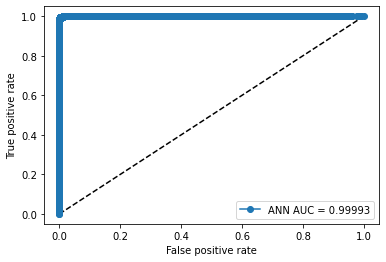

In [57]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='ANN AUC = {:.5f}'.format(auc_keras), marker='o')
#plt.plot(fpr_rf, tpr_rf, label='RFR AUC = {:.5f}'.format(auc_rf), marker='o')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
#plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('roc.png')
plt.show()